### Using Keras Sequential API with tf.GradientTape for training
#### src : https://www.tensorflow.org/tutorials/generative/dcgan

### Steps 
- Generator (Creates images that looks real)
- Discriminator (Distinguishes b/w real and fake images)

### Process
- Keep improving the Generator till the Discriminator is not able to distinguish between them (equilibrium).
- Each step will improve both Generator and Discriminator.

#### Let's start Coding.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [3]:
tf.compat.v1.enable_eager_execution()

#### To Generate GIFs

In [4]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import os
import time
import PIL
from IPython import display
from numba import cuda

%matplotlib inline

tf.keras.backend.clear_session()

#### Load and Prepare Dataset

In [6]:
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [7]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [8]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 64

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

### Model Creation

#### Generator Model

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides = (2,2), padding = 'same' , use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

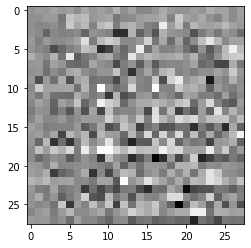

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

### Making the Discriminator

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same', input_shape = [28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,(5,5),strides = (2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00168552]], dtype=float32)>

#### Defining Loss and Optimizers

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### Discriminator Loss

In [15]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

##### Generator Loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

##### Optimizers

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Saving Checkpoints

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

#### Training

In [19]:
EPOCHS = 50
noise_dim = 100
num_ex_to_generate = 16
seed = tf.random.normal([num_ex_to_generate,noise_dim])

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [26]:
def generate_and_save_images(model,epoch, test_input):
    predictions = model(test_input,training=False)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5 + 127.5,cmap='gray')
        plt.axis('off')
        
    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.show()

In [22]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

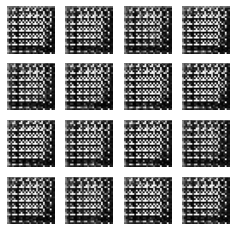

Time for epoch 2 is 97.68595433235168 sec.


In [ ]:
train(train_dataset,EPOCHS)